In [206]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [3]:
from helpers import *
from model_learning import *
import datetime

In [4]:
filename = 'train.csv'
prediction, x_raw, ids = load_csv_data(filename, sub_sample=False)

# Data Exploration

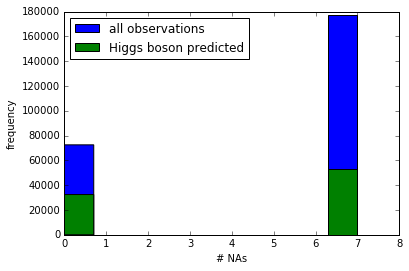

In [88]:
# get the na count per row
naCount = np.sum(x_raw == -999, axis=1)
naCountWithPred = naCount[prediction == 1] # where higgs boson was predicted
#print((naCount[naCount == 7]).shape)
plt.hist(naCount, label='all observations')
plt.hist(naCountWithPred, label='Higgs boson predicted')
plt.legend(loc='best')
plt.xlabel('# NAs')
plt.ylabel('frequency')
plt.show()

In [91]:
featuresToIgnore = []#[8, 23] # starting from zero #[2, 3, 5, 9, 21, 22, 29] #

In [168]:
# replace missing values in each column with median value in this column
def interpolate_with_median(x_raw):
    medians_xraw = np.median(x_raw, axis=0)
    x_proc = x_raw

    for col_index in range(x_raw.shape[1]):
        x_proc[x_raw[:, col_index] == -999, col_index] = medians_xraw[col_index]
        
    return x_proc

# remove unwanted features
def remove_features(x):
    
    x_proc = np.delete(x, featuresToIgnore, axis=1)
    
    return x_proc

#
def clean_data_and_standardize(x_raw, varianceToKeep, toPCABasis_fcn, mean_x=None, std_x=None):
    """
    toPCABasis is a function that returns the data after PCA dimensional reduction
    """
    
    x_proc = interpolate_with_median(x_raw)
    
    #x_proc2 = remove_features(x_proc)
    
    if varianceToKeep is not None:
        if toPCABasis_fcn is not None:
            print("Error: PCA basis should not be given - ignoring")
        toPCABasis_fcn = pca(x_proc, varianceToKeep = varianceToKeep)
    else:
        if (toPCABasis_fcn is None) or (mean_x is None) or (std_x is None):
            print("Error: should specify PCA basis, mean and std of data (used to transform training.csv)")
    
    x_proc2 = toPCABasis_fcn(x_proc)
    
    tx, mean_x, std_x = standardize(x_proc2, mean_x, std_x)
    
    return (tx, mean_x, std_x, toPCABasis_fcn)

def pca(data, varianceToKeep):
    """ varianceToKeep is the fraction variance we want to keep wished, it can be at most 1
    varianceToKeep = 1 means we don't reduce the number of features
    
    Implementation follows the mathematical explanation from
    https://en.wikipedia.org/wiki/Principal_component_analysis
    """
    
    # make data have mean 0
    data_mean = np.mean(data, axis=0)
        
    X = data - data_mean
    covar = X.T @ X
    # find largest eigenvalues, svd does this
    u, s, v = np.linalg.svd(covar)
    retained_variance = np.cumsum(s) / np.sum(s)
    new_PCA_basis = u[:, retained_variance <= varianceToKeep]
    
    # apply this function to X
    convertToPCA = lambda X1 : (X1 - data_mean) @ new_PCA_basis
    return convertToPCA
    
    

In [169]:
print(x_raw.shape)
(tx, mean_x, std_x, toPCABasis_fcn) = clean_data_and_standardize(
    x_raw, varianceToKeep=0.9999, toPCABasis_fcn=None)

tx.shape

(250000, 30)


(250000, 12)

In [124]:
nans_per_column = np.sum(x_raw == -999, axis=0)
# TODO: test if it changes if we remove the features that have many nans for all data

nans_per_column

array([     0,      0,      0,      0, 177457, 177457, 177457,      0,
            0,      0,      0,      0, 177457,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0, 177457, 177457, 177457,      0])

In [128]:
transf_data, new_base = pca(x_raw, varianceToKeep = 0.9999)
print(new_base.shape)
print(transf_data.shape)

(30, 12)
(250000, 12)


In [82]:
# replace missing values in each column with median value in this column
x_proc = interpolate_with_median(x_raw)

# check
# x_proc[x_raw[:, col_index] == -999, :]

In [132]:
print(x_proc.shape)
for variance in [0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 0.999, 0.9999, 0.99999, 1]:
    transf_data, new_base = pca(x_proc, varianceToKeep = variance)
    transf_data_raw, new_base_raw = pca(x_raw, varianceToKeep = variance)

    print("{}: proc: {}".format(variance, new_base.shape), end=', ')
    print("raw: {}".format(new_base_raw.shape))
    #print(transf_data.shape)

(250000, 30)
0.2: proc: (30, 0), raw: (30, 0)
0.4: proc: (30, 0), raw: (30, 0)
0.5: proc: (30, 0), raw: (30, 0)
0.6: proc: (30, 0), raw: (30, 0)
0.7: proc: (30, 0), raw: (30, 0)
0.8: proc: (30, 0), raw: (30, 0)
0.9: proc: (30, 0), raw: (30, 0)
0.99: proc: (30, 2), raw: (30, 2)
0.999: proc: (30, 7), raw: (30, 7)
0.9999: proc: (30, 12), raw: (30, 12)
0.99999: proc: (30, 15), raw: (30, 15)
1: proc: (30, 30), raw: (30, 30)


In [ ]:
transf_data_raw, new_base_raw = pca(x_raw, varianceToKeep = 0.999)

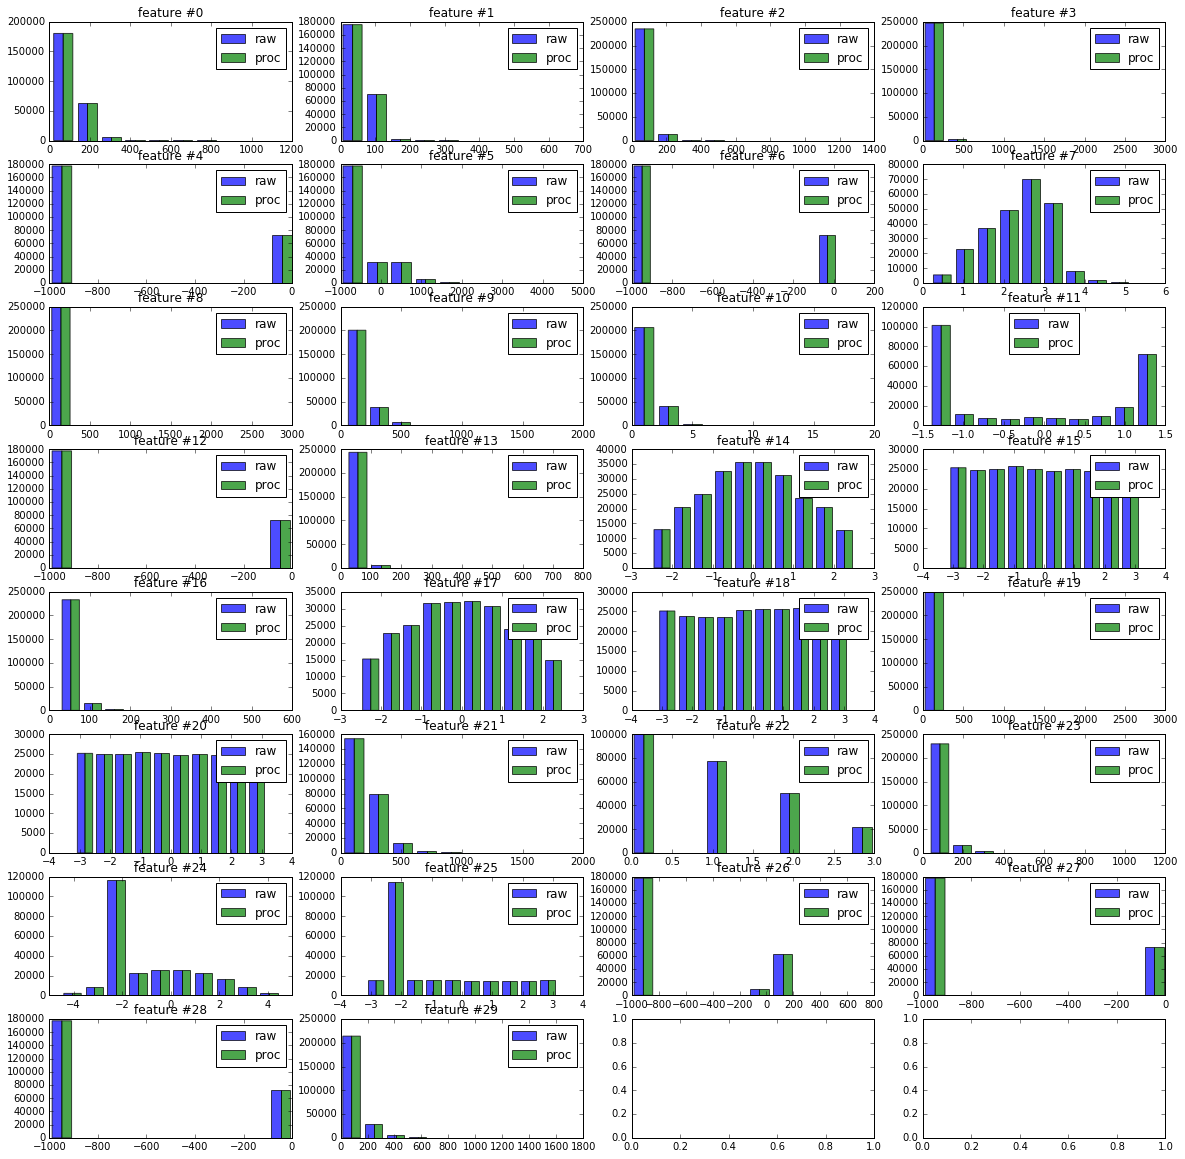

In [126]:
# plot histogram of features

nbFeatures = x_raw.shape[1]
nbCols = 4
nbRows = int(np.ceil(nbFeatures / nbCols))
f, ax = plt.subplots(nbRows, nbCols, figsize=(20,20))
for col_index in range(nbFeatures):
    ax_spec = ax[col_index // nbCols, col_index % nbCols]
    ax_spec.hist(
            [x_raw[:, col_index], x_proc[:, col_index]], label=['raw', 'proc'], alpha=0.7)
    #plt.hist(x_proc[:, col_index], label='proc', alpha=0.5)
    ax_spec.legend(loc='best')
    ax_spec.set_title("feature #{}".format(col_index))
    #break
#f.show()

In [94]:
# safety check
x_proc[x_proc[:, col_index] < 0, :]

array([], shape=(0, 30), dtype=float64)

In [95]:
# ignore features according to above
#featuresToIgnore = [8, 23] # starting from zero
x_proc2 = remove_features(x_proc)

print(x_proc.shape)
print(x_proc2.shape)

(250000, 30)
(250000, 28)


In [97]:
tx, mean_x, std_x = standardize(x_proc2)

txff,_,_ = clean_data_and_standardize(x_proc)
if np.any(np.any(txff - tx)) != 0:
    print("error")

txff - tx
tx.shape

(250000, 28)

In [415]:
# not used
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(x_proc.T)

PCA(copy=True, n_components=2, whiten=False)

In [416]:
print(pca.explained_variance_ratio_)
print(pca.explained_variance_)
print(pca.components_.shape)

[ 0.96367082  0.02784767]
[  3.41575751e+10   9.87068263e+08]
(2, 250000)


In [178]:
def sample_data(x, seed, size_samples):
    """sample from dataset."""
    np.random.seed(seed)
    num_observations = x.shape[0]
    random_permuted_indices = np.random.permutation(num_observations)
    #y = y[random_permuted_indices]
    x = x[random_permuted_indices]
    return x[:size_samples] #y[:size_samples], 

In [214]:
# sampled data to reduce plotting time
sampled_x_proc = sample_data(x_proc, seed=None, size_samples=2000)

# run it only if you have time (approx. 30 seconds), replace 0 below
nbFeatures = 0#10#x_raw.shape[1]
nbCols = 4
nbRows = int(np.ceil(nbFeatures * nbFeatures / nbCols))
f, ax = plt.subplots(nbRows, nbCols, figsize=(20, 5 * nbRows))
for feat1 in range(nbFeatures):
    print("feature #{}".format(feat1))
    for feat2 in range(feat1+1, nbFeatures):
        plotIndex = feat1 * nbFeatures + feat2
        #print(ax.shape)
        ax_spec = ax[plotIndex // nbCols, plotIndex % nbCols]
        ax_spec.scatter(sampled_x_proc[:, feat1], sampled_x_proc[:, feat2])
        #ax_spec.legend(loc='best')
        ax_spec.set_xlabel('feature #{}'.format(feat1))
        ax_spec.set_ylabel('feature #{}'.format(feat2))
        ax_spec.set_title("features #{}-#{}".format(feat1, feat2))
        
f.savefig('correlations.png')

IndexError: index out of range

In [184]:
#f.savefig('correlations.png')

# Predict Weights with Gradient Descent

In [170]:
# Import cleaned data, keep mean_x and std_x for transforming testing data in the end
#tx, mean_x, std_x = clean_data_and_standardize(x_raw)
(tx, mean_x, std_x, toPCABasis_fcn) = clean_data_and_standardize(
    x_raw, varianceToKeep=0.9999, toPCABasis_fcn=None)
print(tx.shape)
print(len(prediction))

(250000, 12)
250000


In [171]:
#from plots import gradient_descent_visualization
from costs import *
from model_learning import *
from cross_validation import k_cross_validation, split_data

nbFeatures = tx.shape[1]

# Define the parameters of the algorithm.
max_iters = 500000
gamma = 0.01
# Initialization

max_iters = 2500
gamma = 0.05
batch_size = 1000
degree = 1

max_iters = 2500
gamma = 0.05
batch_size = 50#int(tx.shape[0]/100)
degree = 1
w_initial = [10] * nbFeatures

# Start gradient desceniit.
start_time = datetime.datetime.now()
#weights = gradient_descent(prediction, tx, w_initial, max_iters, gamma)

#compute_weightsFunctionMSE = lambda y, tx, lambdaIgnored: least_squares_weights(
#        y, tx, gamma=gamma, max_iters=max_iters, batch_size=batch_size)
compute_weightsFunctionMSE = lambda y, tx, lambdaIgnored: exact_least_squares_weights(y, tx)
#weights = stochastic_gradient_descent(prediction, tx, w_initial, batch_size=200, max_iters=max_iters, 
#                                      gamma=gamma, compute_gradientFunction=compute_mse_gradient, compute_lossFunction=compute_mse_loss)

(rmse_tr, rmse_te) = k_cross_validation(prediction, tx, k_fold=5, lambda_=0, degree=degree, seed=1, 
    compute_weightsFunction=compute_weightsFunctionMSE, compute_lossFunction=compute_mse_loss)

compute_weightsFunctionMAE = lambda y, tx, lambdaIgnored: mae_weights(
        y, tx, gamma=gamma, max_iters=max_iters, batch_size=batch_size)
(rmse_tr, rmse_te) = k_cross_validation(prediction, tx, k_fold=5, lambda_=0, degree=degree, seed=1, 
    compute_weightsFunction=compute_weightsFunctionMAE, compute_lossFunction=compute_mae_loss)


end_time = datetime.datetime.now()


print((rmse_tr, rmse_te))
# Print result
execution_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=execution_time))

Stochastic Gradient Descent(0/2499): changeInLoss=0.02757863206586464, loss=28.43403787689534, w0=9.986, w1=9.986128935197272
Stochastic Gradient Descent(250/2499): changeInLoss=0.023943568333116616, loss=20.5795284984566, w0=5.928000000000026, w1=7.1285602683497205
Stochastic Gradient Descent(500/2499): changeInLoss=0.028812853364154734, loss=12.881136731751369, w0=2.400000000000045, w1=4.495670616433189
Stochastic Gradient Descent(750/2499): changeInLoss=0.030728119378136576, loss=5.629330829588645, w0=-0.06199999999995479, w1=1.7223585285547114


KeyboardInterrupt: 

In [102]:
arr = np.array([[1, 2, 4], [2, 3, 4]])
degree = 3
res = build_poly(arr, degree)
print(res.shape)

(2, 10)


# Do Cross Validation

In [172]:
# now implement cross-validation
from model_learning import *
from costs import *
from build_polynomial import *


# define parameters
seeds = range(2)#range(100)
ratio_train = 0.05#0.005 #TODO: change
degrees = [2,3,4,5,6,7, 8, 9, 10, 11, 12, 13]#range(1, 10)
lambdas = np.logspace(-4,3,30)#np.logspace(-4, 2, 30)
k_fold = 5 # used to determine best lambda for given degree (and seed)



#def get_percentage_correct(y, tx, w):
#    return np.mean(y == np.sign(tx.dot(w)))

def cross_validation_extract_weights(seeds, ratio_train, degrees, lambdas, k_fold):
    
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(degrees)))
    rmse_te = np.empty((len(seeds), len(degrees)))
    
    max_iters = 2000
    gamma = 0.001
    batch_size = 2000
    #compute_weightsFunction = lambda y, tx, lamb: ridge_regression_least_squares_weights(
    #    y, tx, lamb, gamma, max_iters, batch_size=batch_size)
    compute_weightsFunction = exact_ridge_regression_least_squares
    compute_lossFunction = compute_mse_loss

    #compute_weightsFunction = lambda y, tx, lamb: ridge_regression_logistic_weights(
    #    y, tx, lamb, gamma, max_iters, batch_size=batch_size)
    #compute_lossFunction = compute_logistic_loss
    
    # we later on average over the seeds
    for index_seed, seed in enumerate(seeds):
        print("Starting with seed #{}".format(index_seed))
        
        (x_tr, y_tr, x_te, y_te) = split_data(tx, prediction, ratio_train, seed=seed)
        
        #print(x_tr.shape)
        #print(y_tr.shape)
        #print(compute_lossFunction(y_tr, x_tr, np.repeat(0, x_tr.shape[1])))
        
        for index_degree, degree in enumerate(degrees):
            
            # find optimal lambda for this degree by using training set only
            
            cross_rmse_lambdas = []
            for lambda_ in lambdas:
                print("Taking degree {}, lambda {}".format(degree, lambda_))
                (cross_rmse_tr, cross_rmse_te) = k_cross_validation(
                    y_tr, x_tr, k_fold, lambda_, degree, seed,
                    compute_weightsFunction=compute_weightsFunction, compute_lossFunction=compute_lossFunction)
                
                # we are only interested in the error on the test set (part of the training set)
                cross_rmse_lambdas.append(cross_rmse_te)
            # best lambda corresponds to lambda minimising the testing error for 
            # k-fold validation on the training set
            bestLambdaIndex = np.argmin(cross_rmse_lambdas)
            bestLambda = lambdas[bestLambdaIndex]
            print("Best lambda for degree {}: {} (index {})".format(degree, bestLambda, bestLambdaIndex))
            
            # add polynomial features
            x_poly_tr = build_poly(x_tr, degree)
            x_poly_te = build_poly(x_te, degree)
                 
            # compute weights with ridge_regression on training set with given lambda (and degree)
            weights_tr = compute_weightsFunction(y_tr, x_poly_tr, lamb = bestLambda)
            # find the testing error
            mse_tr = compute_lossFunction(y_tr, x_poly_tr, weights_tr)
            mse_te = compute_lossFunction(y_te, x_poly_te, weights_tr)
            rmse_tr_val = np.sqrt(2*mse_tr)
            rmse_te_val = np.sqrt(2*mse_te)
            
            #rmse_tr_val = get_percentage_correct(y_tr, x_poly_tr, weights_tr)
            #rmse_te_val = get_percentage_correct(y_te, x_poly_te, weights_tr)
                    
            rmse_tr[index_seed, index_degree] = rmse_tr_val
            rmse_te[index_seed, index_degree] = rmse_te_val
            
    # mean over all seeds, then just have for each degree
    mean_rmse_tr = np.mean(rmse_tr, axis=0)
    mean_rmse_te = np.mean(rmse_te, axis=0)
    
    return (mean_rmse_tr, mean_rmse_te)



(mean_rmse_tr, mean_rmse_te) = cross_validation_extract_weights(seeds, ratio_train, degrees, lambdas, k_fold)

bestDegree = degrees[np.argmin(mean_rmse_te)]
#bestDegree = degrees[np.argmax(mean_rmse_te)]

#seed = np.random.seed()
print(bestDegree)
    
print(mean_rmse_tr)
print(mean_rmse_te)

Starting with seed #0
Taking degree 2, lambda 0.0001
Taking degree 2, lambda 0.00017433288221999874
Taking degree 2, lambda 0.0003039195382313198
Taking degree 2, lambda 0.0005298316906283707
Taking degree 2, lambda 0.0009236708571873865
Taking degree 2, lambda 0.0016102620275609393
Taking degree 2, lambda 0.0028072162039411755
Taking degree 2, lambda 0.004893900918477494
Taking degree 2, lambda 0.008531678524172814
Taking degree 2, lambda 0.014873521072935119
Taking degree 2, lambda 0.02592943797404667
Taking degree 2, lambda 0.04520353656360245
Taking degree 2, lambda 0.07880462815669913
Taking degree 2, lambda 0.1373823795883264
Taking degree 2, lambda 0.2395026619987486
Taking degree 2, lambda 0.4175318936560405
Taking degree 2, lambda 0.7278953843983154
Taking degree 2, lambda 1.2689610031679235
Taking degree 2, lambda 2.21221629107045
Taking degree 2, lambda 3.856620421163472
Taking degree 2, lambda 6.723357536499335
Taking degree 2, lambda 11.721022975334817
Taking degree 2, lam

In [174]:
bestDegree

2

# Estimate Testing Error

In [99]:
def get_fraction_correct(y, tx, w):
    return np.mean(y == np.sign(tx.dot(w)))

In [ ]:
#bestDegree = 5
#bestLambda = 0.2395026619987486#10#0.5#0.02592943797404667

bestDegree = 5
bestLambda = 573.6152510448682

bestDegree = 13
bestLambda = 1#0.1373823795883264

compute_weightsFunction = exact_ridge_regression_least_squares
compute_lossFunction = compute_mse_loss
seed = 1
ratio_train = 0.05

(x_tr, y_tr, x_te, y_te) = split_data(tx, prediction, ratio_train, seed=seed)

# add polynomial features
x_poly_tr = build_poly(x_tr, bestDegree)
x_poly_te = build_poly(x_te, bestDegree)

# compute weights with ridge_regression on training set with given lambda (and degree)
weights_tr = compute_weightsFunction(y_tr, x_poly_tr, lamb = bestLambda)
# find the testing error
#mse_tr = compute_lossFunction(y_tr, x_poly_tr, weights_tr)
#mse_te = compute_lossFunction(y_te, x_poly_te, weights_tr)
#rmse_tr_val = np.sqrt(2*mse_tr)
#rmse_te_val = np.sqrt(2*mse_te)

#y_te_pred = predict_labels(weights_tr, x_te)

weights_real = weights_tr # used for real data

get_fraction_correct(y_tr, x_poly_tr, weights_tr)

Recomputed
(12500, 1820)
(12500, 108)


In [241]:
# Import data
filenameNew = 'test.csv'
prediction_wrong, x_real_raw, ids_real = load_csv_data(filenameNew, sub_sample=False)

In [243]:

#tx_real, mean_x_wrong, std_x_wrong = clean_data_and_standardize(x_real_raw, mean_x=mean_x, std_x=std_x)
(tx_real, mean_x_wrong, std_x_wrong, toPCABasis_fcn_unused) = clean_data_and_standardize(
    x_real_raw, varianceToKeep=None, toPCABasis_fcn=toPCABasis_fcn, mean_x=mean_x, std_x=std_x)

#tx_real, mean_x_wrong, std_x_wrong = standardize(x_real_raw, mean_x=mean_x, std_x=std_x)

x_poly_real = build_poly(tx_real, bestDegree)

y_pred = predict_labels(weights_real, x_poly_real)

create_csv_submission(ids_real, y_pred, 'submission.csv')

(568238, 455)
(568238, 120)


In [244]:
print(sum(y_pred == 1) / len(y_pred))
print(len(y_pred))

0.307138910105
568238


In [508]:
print(mean_rmse_tr)
print(mean_rmse_te)

bestDegree = degrees[np.argmax(mean_rmse_te)]
print(bestDegree)

[ 0.7482  0.7742  0.78    0.7404]
[ 0.73925455  0.76257778  0.7725899   0.73132929]
3


In [ ]:
final_weights = weights[-1]

In [26]:
filenameNew = 'test.csv'
prediction_wrong, x_new_raw, ids_new = load_csv_data(filenameNew, sub_sample=False)

tx_new, mean_x_new, std_x_new = standardize(x_new_raw, mean_x=mean_x, std_x=std_x)

#TODO: add build_poly
y_pred = predict_labels(final_weights, tx_new)

create_csv_submission(ids_new, y_pred, 'submission.csv')

In [218]:
f = lambda x,y: print(y, x, y)
f(1,2)

2 1 2


In [27]:
! du -h submission.csv test.csv
#! cat submission.csv | head

5.9M	submission.csv
105M	test.csv


In [28]:
y_pred == 1

array([False, False, False, ..., False,  True, False], dtype=bool)

In [35]:
#len(tx_new)
#len(x_new_raw)
#len(prediction_wrong)
len(y_pred)
len(ids_new)

568238

In [1]:
cat submission.csv | head











cat: write error: Broken pipe
